In [ ]:
#Dan's code for Col dens, unedited/ not tested

In [7]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import xarray as xr

In [2]:
def o3_column(waccm_file):
    
    print("opening : ", waccm_file)
    ds = xr.open_dataset(waccm_file, decode_times=False )
    
    # define some constants need for the column integration
    kboltz = 1.380044E-16   # boltzman's constant (erg/K)
    R = 2.8704e6            # gas constant (erg/g/K)
    g = 980.616             # grav acceleration (cm/sec2)
    pa2dyn = 10.            # Pascals to dyn/cm2
    cm2todu = 1./2.6867e16  # convert colunm density / cm^2 to Dobson units

    ds = xr.open_dataset(waccm_file)
    plev = ds['lev']
    
    #calcualte column integrals 
    o3 = ds['O3'].values
    
    # variables to calcualate hybrid pressure on model interfaces
    ps = ds['PS'].values # surface pressure
    p0 = ds['P0'].values
    hyai = ds['hyai'].values
    hybi = ds['hybi'].values
    
    col = np.ndarray(ps.shape, np.float32)
    dp = np.ndarray(o3.shape, np.float32)
    
    nt = ds['time'].size
    ny = ds['lat'].size
    nz = ds['lev'].size
    
    press = np.ndarray(nz, np.float32)
    for it in range(nt):
        for iy in range(ny):
            press = hyai * p0 + hybi * ps[it,iy]
            for iz in range(nz):
                 dp[it,iz,iy] = (press[iz+1]-press[iz])

    o3 = o3 * dp * R / (kboltz * g)

    o3col = np.sum(o3, axis = 1) *  pa2dyn * cm2todu
    
    #calculate global mean time series

    lat = ds['lat'].values
    time = ds['time'].values
    wts = np.cos(np.pi*lat/180.)
    wts_total = np.sum(wts)

    gm_o3col = o3col@wts/wts_total

    #create output Dataset
    
    ds2 = xr.Dataset({'o3_col': (['lat', 'time'], np.transpose(o3col)),
                      'gm_o3col': (['time'], gm_o3col),},
                     coords={'lat': (['lat'], lat),
                             'time': (['time'], time)})

    ds3 = xr.merge([ds2, ds['time_bnds'], ds['date'], ds['datesec']]) 
    ds3.lat.attrs["units"] = "degrees_north"
    ds3.o3_col.attrs["units"] = "DU"
    ds3.gm_o3col.attrs["units"] = "DU"

    return ds3

In [3]:
data_dir = '/home/home01/phydrm/python/example_data/'
waccm_file = 'b.e21.BWma1850.f19_g17.baseline.fin.001.cam.h0zm.0010.nc'

dso3 = o3_column(data_dir+waccm_file)

outfile = "o3column.nc"
dso3.to_netcdf(outfile)

opening :  /home/home01/phydrm/python/example_data/b.e21.BWma1850.f19_g17.baseline.fin.001.cam.h0zm.0010.nc


[ 1  2  3  4  5  6  7  8  9 10 11 12]


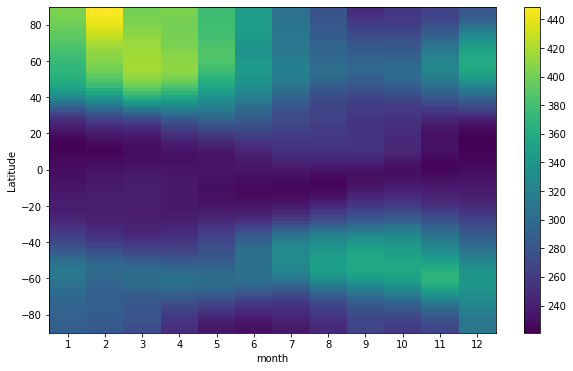

In [9]:
month = dso3['time_bnds'].mean(dim='nbnd').dt.month.values
lat = dso3['lat'].values
du = dso3['o3_col']
print(month)

plt.figure(figsize=(10,6))
plt.imshow(du, aspect='auto', origin='lower', 
           interpolation = 'none', extent = [0.5,12.5,-90,90])

cb = plt.colorbar()
tick_locator = ticker.MaxNLocator(nbins=12)
cb.locator = tick_locator
cb.update_ticks()

ax = plt.gca()
ax.set_xlabel('month')
ax.set_ylabel('Latitude')
ax = plt.gca()
ax.set_xticks(month)

plt.show()